---
# 👶🏻🍼 Classificazione automatica del pianto neonatale mediante reti neurali: Transfer learning con PANNs (CNN pre-addestrata) + classificatore MLP
---
By: Beatrice & Giorgia 👩🏻 👩🏻‍🦰


---

1.   **SET UP:**
installazioni, importo librerie


2.   **VISIONE GLOBALE DEL DATASET:** frequenza classi, statistiche durata audio

3.   **PCA:** 2D, 3D, Scree plot

4. **DATA AUGMENTATION:** split dataset (75%-15%-10%), data augmentation on-the-fly

5. **TRANSFER LEARNING:** estraggo e salvo embeddings audio usando il modello pre-addestrato PANNs

6. **TRAIN:** classificatore MLP, loss (crossEntropy), ottimizzatore Adam con scheduler, early stopping

7. **RISULTATI OTTENUTI:** andamento della loss e dell'errore, matrice di confusione (multiclasse e binaria)






##⚙️ SET UP

In [ ]:
!pip install audiomentations
!pip install torchlibrosa git+https://github.com/qiuqiangkong/panns_inference.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0
  Cloning https://github.com/qiuqiangkong/panns_inference.git to /tmp/pip-req-build-0_9iwgyg
  Running command git clone --filter=blob:none --quiet https://github.com/qiuqiangkong/panns_inference.git /tmp/pip-req-build-0_9iwgyg
  Resolved https://github.com/qiuqiangkong/panns_inference.git to commit f673f604ec6f4805a61c5b3be087e24776ec5fda
  Preparing metadata (setup.py) ... done
  Created wheel for panns-inference: filename=panns_inference-0.1.1-py3-none-any.whl size=8266 sha256=7e55710942958e066d7d7da4e7b63ec2e1971074ca1efb8f3e3be2aa1759d8a9
  Stored in directory: /tmp/pip-ephem-wheel-cache-raq7pdnk/wheels/5

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import plotly.express as px
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa.display
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, ClippingDistortion, PolarityInversion
from torchvision import models
from sklearn.manifold import TSNE
from panns_inference import AudioTagging
from tqdm import tqdm





In [ ]:
# Cloniamo l'intero repository
!git clone https://github.com/gveres/donateacry-corpus.git

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616 (from 1)
Receiving objects: 100% (1616/1616), 67.06 MiB | 18.10 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (1587/1587), done.


In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

## 🗂️ VISIONE GLOBALE DEL DATASET

Leggo tutto il dataset, estraggo informazioni dai file audio e capisco come sono distribuiti i dati.



Numero file per dataset:
dataset
donateacry-android-upload-bucket              712
donateacry-ios-upload-bucket                  416
donateacry_corpus_cleaned_and_updated_data    457
Name: file, dtype: int64

Numero file per classe in ciascun dataset:
dataset                                     label                           
donateacry-android-upload-bucket            donateacry-android-upload-bucket    712
donateacry-ios-upload-bucket                donateacry-ios-upload-bucket        416
donateacry_corpus_cleaned_and_updated_data  belly_pain                           16
                                            burping                               8
                                            discomfort                           27
                                            hungry                              382
                                            tired                                24
Name: file, dtype: int64

Statistiche sulla durata (secondi):
                    

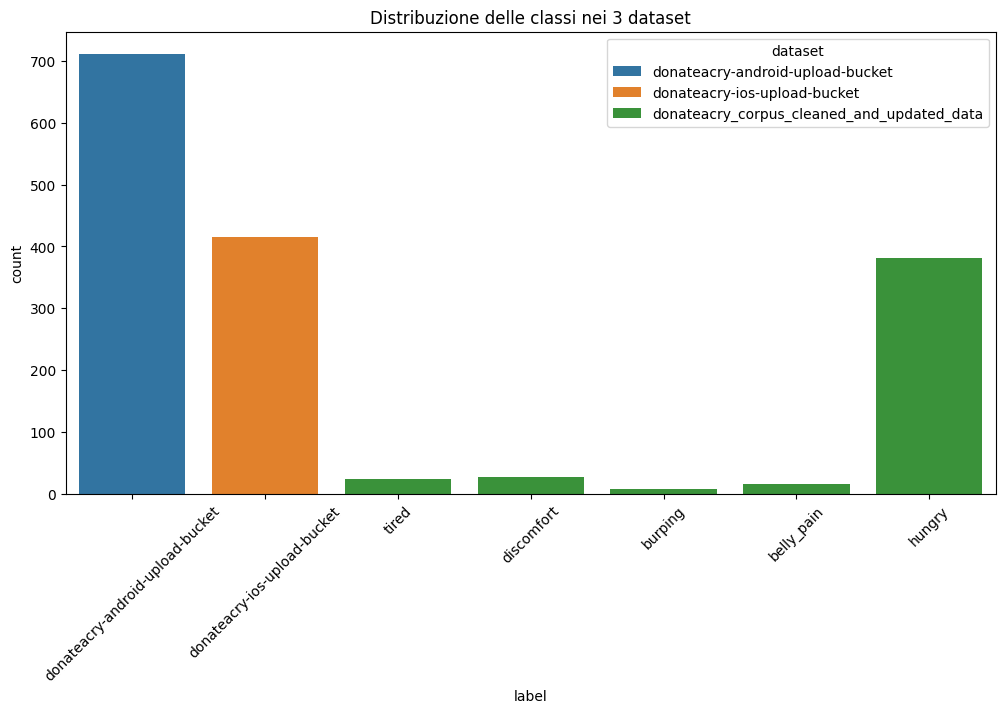

In [ ]:
# Percorso principale del dataset
base_path = "donateacry-corpus"

# Cartelle da analizzare (3 dataset)
folders = [
    "donateacry-android-upload-bucket",
    "donateacry-ios-upload-bucket",
    "donateacry_corpus_cleaned_and_updated_data"
]

results = []

# Loop su tutte le cartelle
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for root, dirs, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith((".wav", ".caf", ".3gp")):
                filepath = os.path.join(root, file)
                try:
                    y, sr = librosa.load(filepath, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr) #calcola durata
                    results.append([folder, label, file, sr, duration]) #salvo l'informazione
                except Exception as e:
                    print(f"Errore su {filepath}: {e}")

#DataFrame con i metadati
df = pd.DataFrame(results, columns=["dataset", "label", "file", "sample_rate", "duration"])

# Calcolo le statistiche sui dati

#Conta quanti file ci sono in ciascun dataset
print("\nNumero file per dataset:")
print(df.groupby("dataset")["file"].count())

#Mostra la distribuzione delle classi per ogni datset
print("\nNumero file per classe in ciascun dataset:")
print(df.groupby(["dataset", "label"])["file"].count())

#Calcola statistiche descrittive della durata dei file audio per dataset
print("\nStatistiche sulla durata (secondi):")
print(df.groupby("dataset")["duration"].describe())

# Grafico: Istogramma di distribuzione delle 5 classi
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="label", hue="dataset")
plt.title("Distribuzione delle classi nei 3 dataset")
plt.xticks(rotation=45)
plt.show()



Numero file per classe binaria (dataset pulito):
binary_label
hungry        382
not_hungry     75
Name: count, dtype: int64

Percentuali:
binary_label
hungry        83.59
not_hungry    16.41
Name: count, dtype: float64


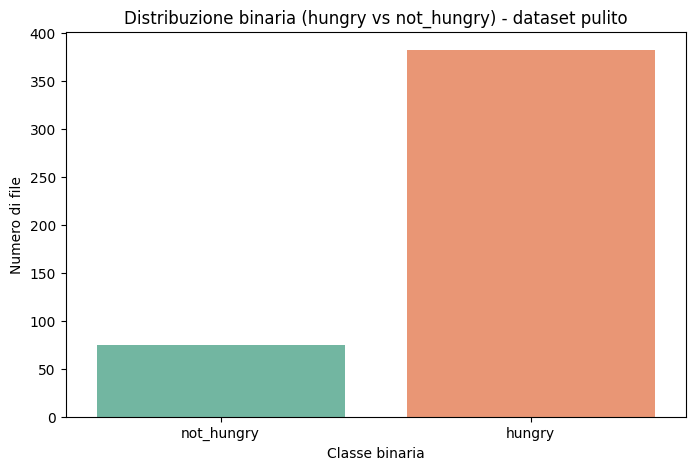

In [ ]:
#Normalizzo le etichette a lower-case per coerenza
df["label"] = df["label"].str.lower()

# Aggiungo colonna binaria hungry / not_hungry
df["binary_label"] = df["label"].apply(lambda x: "hungry" if x == "hungry" else "not_hungry")


# Statistiche binarie (solo dati puliti)
df_clean = df[df["dataset"] == "donateacry_corpus_cleaned_and_updated_data"]
df_clean["label"] = df_clean["label"].str.lower()
df_clean["binary_label"] = df_clean["label"].apply(lambda x: "hungry" if x == "hungry" else "not_hungry")

#Calcolo quanti esempi ho per classe
print("\nNumero file per classe binaria (dataset pulito):")
count_bin = df_clean["binary_label"].value_counts()
print(count_bin)

print("\nPercentuali:")
percent_bin = (count_bin / count_bin.sum() * 100).round(2)
print(percent_bin)

#Grafico: Istogramma di distribuzione delle classi
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x="binary_label", palette="Set2")
plt.title("Distribuzione binaria (hungry vs not_hungry) - dataset pulito")
plt.xlabel("Classe binaria")
plt.ylabel("Numero di file")
plt.show()


##🔢 PCA

PCA 2D e Scree plot PCA

Label mapping: {'tired': 0, 'discomfort': 1, 'burping': 2, 'belly_pain': 3, 'hungry': 4}
Totale file: 457
hungry        382
discomfort     27
tired          24
belly_pain     16
burping         8
Name: count, dtype: int64
Explained variance ratio: [0.29157373 0.1389162 ]


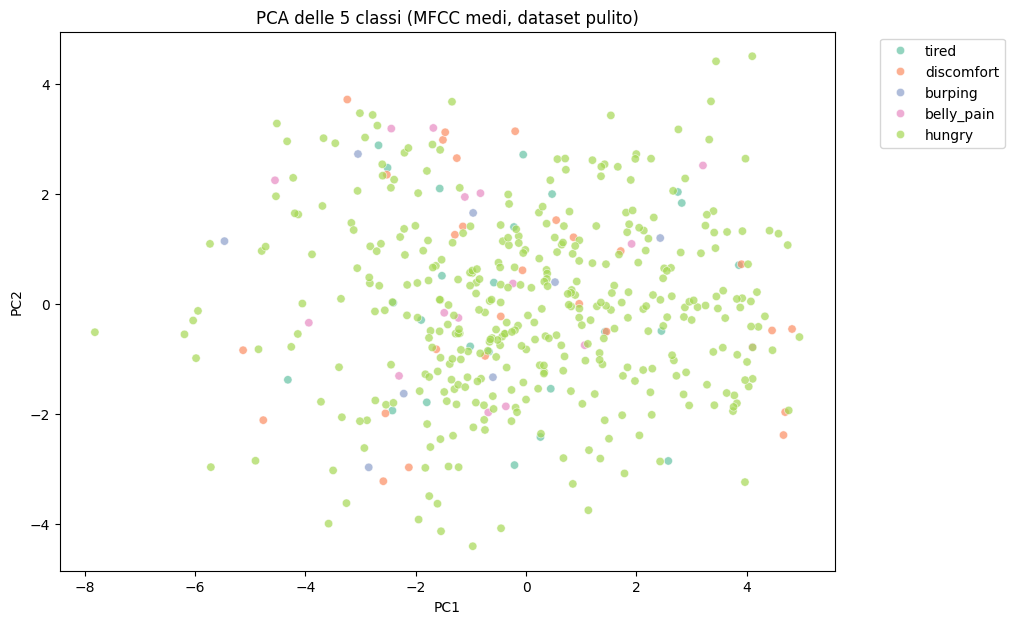

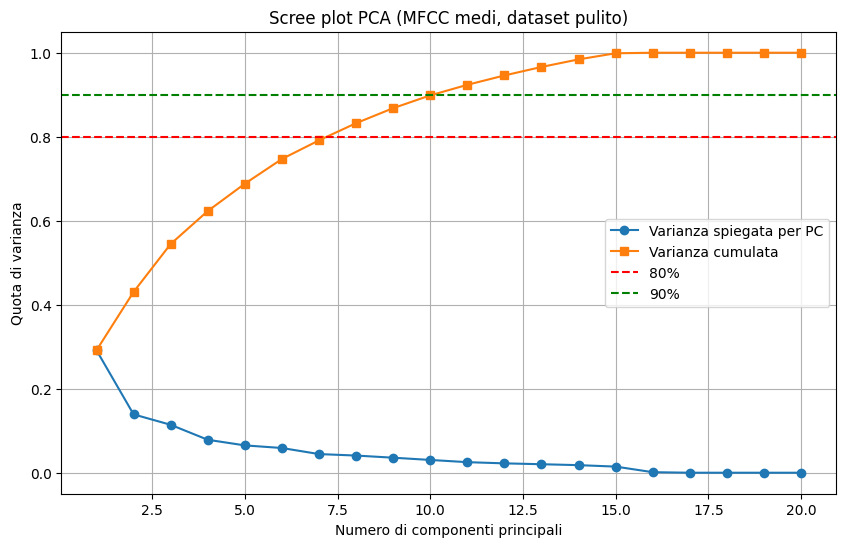

In [ ]:
# Path dataset pulito
data_path = "donateacry-corpus/donateacry_corpus_cleaned_and_updated_data"

file_paths = []
labels = []
label2idx = {}  # mapping label->indice
idx = 0

# Raccolgo file e label
for label in os.listdir(data_path):
    label_folder = os.path.join(data_path, label)
    if os.path.isdir(label_folder):
        label2idx[label] = idx
        for file in os.listdir(label_folder):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(label_folder, file))
                labels.append(label)
        idx += 1

print("Label mapping:", label2idx) #Associo a ogni classe un label
print(f"Totale file: {len(file_paths)}") #Conto quanti file ho in totale
print(pd.Series(labels).value_counts())

# Estrazione feature audio: MFCC
features = []
for filepath in file_paths:
    y, sr = librosa.load(filepath, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20) #calcolo MFCC
    mfcc_mean = np.mean(mfcc, axis=1)   # media sui frame temporali
    features.append(mfcc_mean) #Lo aggiungo

X = np.array(features) #matrice feature n_file x 20
y = np.array(labels) #vettore etichette

# Standardizzazione: per ogni feature media 0, varianza 1 -> per evitare che alcune dimensioni dominino sulle altre
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 2D: riduco la dimensionalita 20->2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Creo un grafico 2D con i punti proiettati sulle due componenti principali
df_pca = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "label": y
})

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="label",
    palette="Set2",
    alpha=0.7
)
plt.title("PCA delle 5 classi (MFCC medi, dataset pulito)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# PCA con tutte le 20 componenti
pca_full = PCA(n_components=X_scaled.shape[1])
pca_full.fit(X_scaled)

explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)

# Creo grafico Scree plot
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', linestyle='-', label="Varianza spiegata per PC")
plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='s', linestyle='-', label="Varianza cumulata")
plt.axhline(y=0.8, color='r', linestyle='--', label="80%")
plt.axhline(y=0.9, color='g', linestyle='--', label="90%")
plt.xlabel("Numero di componenti principali")
plt.ylabel("Quota di varianza")
plt.title("Scree plot PCA (MFCC medi, dataset pulito)")
plt.legend()
plt.grid(True)
plt.show()




PCA 3D

In [ ]:
# PCA 3D
pca_3d = PCA(n_components=3)
X_pca3 = pca_3d.fit_transform(X_scaled)

print("Varianza spiegata dalle prime 3 componenti:", pca_3d.explained_variance_ratio_)

df_pca3 = pd.DataFrame({
    "PC1": X_pca3[:,0],
    "PC2": X_pca3[:,1],
    "PC3": X_pca3[:,2],
    "label": y
})

fig = px.scatter_3d(
    df_pca3,
    x="PC1", y="PC2", z="PC3",
    color="label",
    opacity=0.7,
    title="PCA 3D interattiva (MFCC medi, dataset pulito)",
    size_max=5
)

# Forza che tutti i punti abbiano la stessa taglia
fig.update_traces(marker=dict(size=4))
fig.show()

Varianza spiegata dalle prime 3 componenti: [0.29157373 0.1389162  0.11410654]


##📊 DATA AUGMENTATION

Split stratificato: 75% train - 15% validation - 10% test

In [ ]:
# train 75%, temp 25%
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.25, stratify=labels, random_state=42)

# temp 25% -> validation 15% + test 10%
val_size = 3/5
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1-val_size, stratify=y_temp, random_state=42)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 342 Val: 69 Test: 46


Definizione data augmentation on-the-fly (da applicare solo al train set)

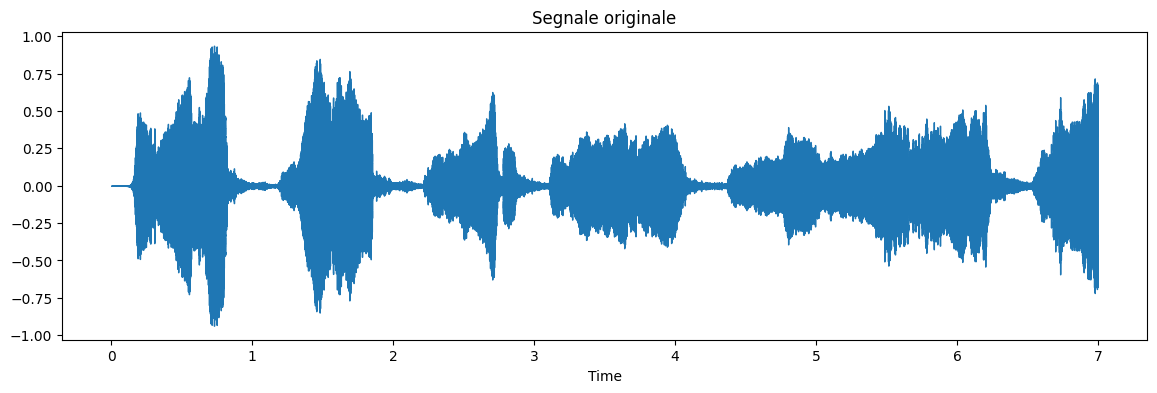

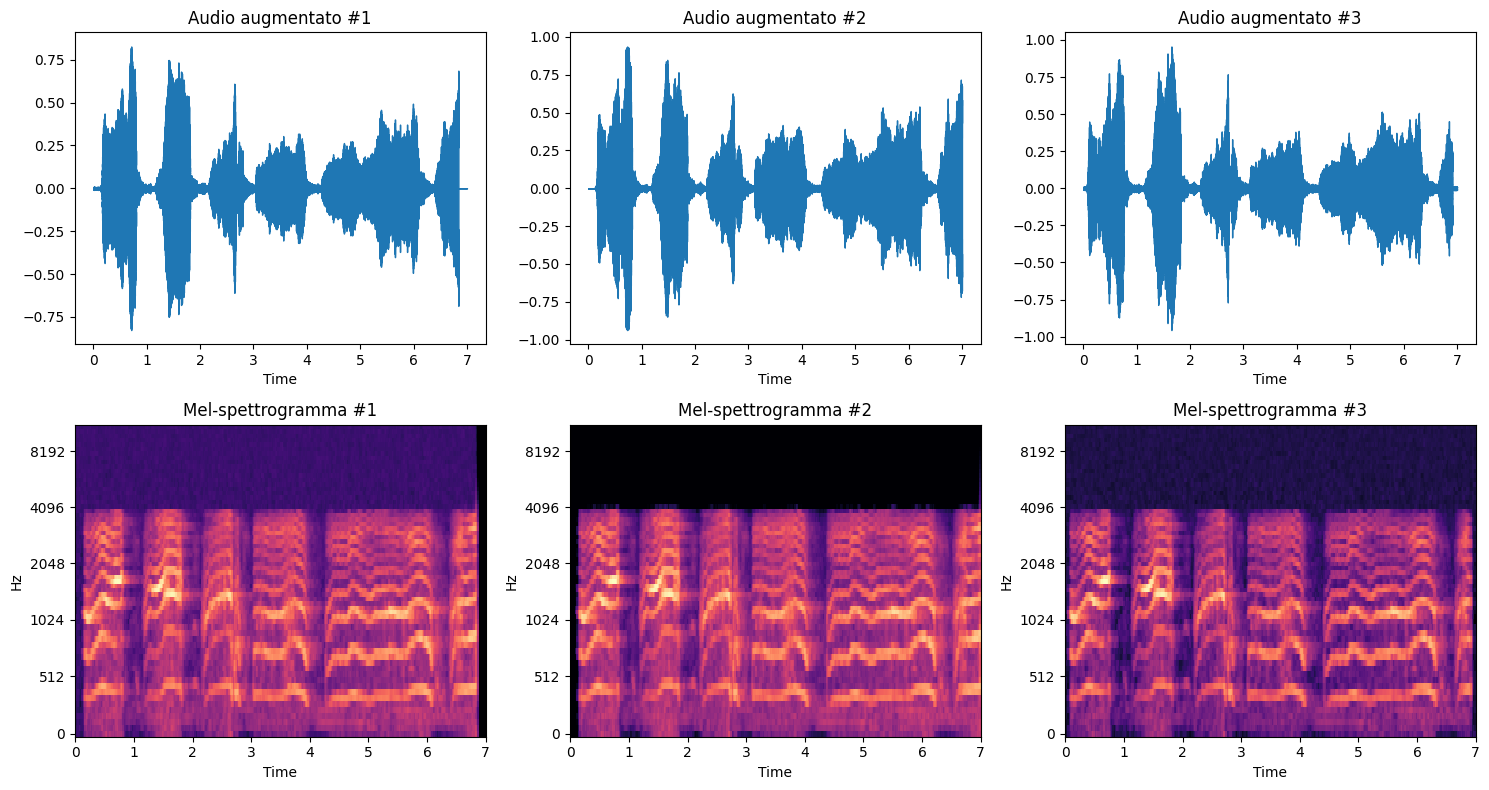

In [ ]:
#Combino tutte queste trasformazioni, dove ognuna viene applicata in modo probabilistico e indipendente
augment_train = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.008, p=0.45),  # Rumore bianco
    TimeStretch(min_rate=0.95, max_rate=1.05, p=0.3),                    # Cambia la velocità del file audio
    PitchShift(min_semitones=-0.5, max_semitones=0.5, p=0.3),            # Sposta la tonalità (pitch) del segnale di pochi semitoni
    Shift(min_shift=-0.05, max_shift=0.05, p=0.3),                       # Sposta il segnale nel tempo (verso destra o sinistra)
    Gain(min_gain_db=-4.0, max_gain_db=4.0, p=0.3),                      # Aumenta o riduce il volume dell’audio in decibel
    ClippingDistortion(max_percentile_threshold=5, p=0.1),               # Applica una distorsione, tagliando i picchi del segnale oltre una certa soglia
    PolarityInversion(p=0.1),                                            # Inverte la fase del segnale audio
])

augment_none = None  # per validation e test


#Visualizzo un audio in wave form originale, 3 versioni augmentate dello stesso dato sia in versione wave che in versione spettrogramma

test_file = X_train[5]

y, sr = librosa.load(test_file, sr=22050)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Segnale originale")
plt.show()

n_versions = 3
plt.figure(figsize=(15, 8))

for i in range(n_versions):
    y_aug = augment_train(samples=y, sample_rate=sr)

    plt.subplot(2, n_versions, i+1)
    librosa.display.waveshow(y_aug, sr=sr)
    plt.title(f"Audio augmentato #{i+1}")


    mel_spec = librosa.feature.melspectrogram(y=y_aug, sr=sr, n_mels=64)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.subplot(2, n_versions, n_versions + i + 1)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
    plt.title(f"Mel-spettrogramma #{i+1}")

plt.tight_layout()
plt.show()


## 👩‍🏫 TRANSFER LEARNING

In [ ]:
#Imposta il dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Carica il modello PANNs (AudioTagging) sul dispositivo scelto
#PANNs: Modello pre-addestrato su un grande dataset di suoni (AudioSet) e serve per estrarre feature audio generiche
panns_model = AudioTagging(checkpoint_path=None, device=device)

#Classe per leggere i dati già transformati in embeddings
class CryEmbeddingsDataset(Dataset):
    def __init__(self, embeddings_file):
        self.embeddings, self.labels = torch.load(embeddings_file)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


os.makedirs("embeddings", exist_ok=True)

#Funzione che genera e salva gli embeddings per un certo split del dataset (train, val o test).
def save_embeddings(file_paths, labels, split_name, label2idx):
    embeddings_list = []
    labels_list = []

    for i, (filepath, label) in enumerate(tqdm(zip(file_paths, labels), total=len(file_paths))):
        y, sr = librosa.load(filepath, sr=32000, mono=True)
        #Estrazione embeddings
        with torch.no_grad():
            _, embedding = panns_model.inference(y[None, :])
        # Normalizzazione e salvataggio temporaneo
        embedding = torch.tensor(embedding, dtype=torch.float32).squeeze(0)
        embedding = embedding / (embedding.norm() + 1e-6)
        embeddings_list.append(embedding)
        labels_list.append(label2idx[label]) # Convert label string to integer index

    # Salvataggio
    embeddings_tensor = torch.stack(embeddings_list)
    labels_tensor = torch.tensor(labels_list, dtype=torch.long)
    torch.save((embeddings_tensor, labels_tensor), f"embeddings/{split_name}.pt")
    print(f"Saved embeddings for {split_name} ({len(labels_list)} samples).")

# Salva embeddings per ogni set
save_embeddings(X_train, y_train, "train", label2idx)
save_embeddings(X_val, y_val, "val", label2idx)
save_embeddings(X_test, y_test, "test", label2idx)

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


100%|██████████| 342/342 [05:17<00:00,  1.08it/s]


Saved embeddings for train (342 samples).


100%|██████████| 69/69 [01:04<00:00,  1.06it/s]


Saved embeddings for val (69 samples).


100%|██████████| 46/46 [00:41<00:00,  1.12it/s]

Saved embeddings for test (46 samples).


## 🧠 TRAIN

In [ ]:
#=======================
#Preparazione dati
#=======================
batch_size = 24

#Carica i dataset precomputati (embeddings PANNs + label)
train_dataset = CryEmbeddingsDataset("embeddings/train.pt")
val_dataset   = CryEmbeddingsDataset("embeddings/val.pt")
test_dataset  = CryEmbeddingsDataset("embeddings/test.pt")

# Calcola class_counts dai label già numerici
class_counts = np.bincount(train_dataset.labels.numpy())
class_weights = 1. / class_counts
#sample_weights = [class_weights[label] for label in train_dataset.labels.numpy()]
#sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

#Creo i DataLoader
#train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#=======================
#Definizione del modello
#=======================
embedding_dim = 2048  # CNN14
hidden_dim = 512 #1024 prima
n_classes = len(label2idx)

#MLP semplice:
#Input: l’embedding PANNs (2048 valori)
#1 hidden layer da 256 neuroni con BatchNorm, ReLU, e Dropout
#Layer lineare -> BatchNorm -> ReLU -> Dropout -> Layer lineare finale
#Output: logits per la classificazione (n_classes neuroni)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.drop1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        #NUOVI
        #self.fc3 = nn.Linear(hidden_dim, output_dim)
        #self.drop2 = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.drop1(x)
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        """Ritorna le feature dopo il primo layer (prima del classificatore finale)."""
        x = torch.relu(self.bn1(self.fc1(x)))
        return x

mlp_model = SimpleMLP(embedding_dim, hidden_dim, n_classes).to(device)

#===================================
#Funzione di perdita e ottimizzatore
#===================================

# CrossEntropyLoss con pesi inversi per classe
weights = 1. / class_counts
#weights = torch.tensor(weights, dtype=torch.float32).to(device)
weights = torch.tensor(np.clip(weights, 0, 10), dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights) #CrossEntropyLoss pesata inversamente alla frequenza delle classi
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4, weight_decay=1e-3) #Ottimizzatore: Adam con regolarizzazione L2 (aggiorno pesi)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6) #Scheduler: riduce il learning rate se la val_loss non migliora.

# =======================
# Early stopping
# =======================
#Definzione classe Eraly stopping
class EarlyStopping:
    def __init__(self, patience=30, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=30)

# =======================
#Ciclo di training
# =======================
#Per ogni epoca:
#Training: forward + backward + update pesi; calcola accuracy e recall su train.
#Validation: forward senza aggiornamento pesi; calcola accuracy, recall e validation loss.
#Salva il modello migliore (minima val_loss).
#Aggiorna scheduler e verifica early stopping.
#Stampa metriche per epoca e recall per classe.

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float('inf')


n_epochs = 200

for epoch in range(n_epochs):
    # ------Train------
    mlp_model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    for spec, label in train_loader:
        spec, label = spec.to(device), label.to(device)
        optimizer.zero_grad() #Azzeramento gradienti
        outputs = mlp_model(spec) #Forward pass → calcolo output
        loss = criterion(outputs, label) #Calcolo loss
        loss.backward() #Backpropagation
        optimizer.step() #Aggiornamento pesi
        running_loss += loss.item() #Accumula la loss

        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    #Calcola accuracy e recall macro sul train set
    acc_train = np.mean(np.array(all_preds) == np.array(all_labels))
    recall_train = recall_score(all_labels, all_preds, average='macro')

    # ---- Validation ----
    mlp_model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for spec, label in val_loader:
            spec, label = spec.to(device), label.to(device)
            outputs = mlp_model(spec)
            _, predicted = outputs.max(1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(label.cpu().numpy())

    #Calcola accuracy e recall macro per validation
    acc_val = np.mean(np.array(val_preds) == np.array(val_labels))
    recall_val = recall_score(val_labels, val_preds, average='macro')
    recall_val_per_class = recall_score(val_labels, val_preds, average=None)


    # Calcolo della validation loss media
    val_loss_total = 0
    with torch.no_grad():
        for spec, label in val_loader:
            spec, label = spec.to(device), label.to(device)
            outputs = mlp_model(spec)
            loss = criterion(outputs, label)
            val_loss_total += loss.item()
    val_loss_mean = val_loss_total / len(val_loader)

    #Salva miglior modello
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        torch.save(mlp_model.state_dict(), "best_model.pt")
        print(f"Miglior modello salvato all'epoca {epoch+1} (val_loss={val_loss_mean:.4f})")

    #Stampa metriche
    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {running_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss_mean:.4f} | "
          f"Train Acc: {acc_train:.4f} | Train Recall: {recall_train:.4f} | "
          f"Val Acc: {acc_val:.4f} | Val Recall: {recall_val:.4f}")


    # Salva le metriche per grafici
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss_mean)
    train_accuracies.append(acc_train)
    val_accuracies.append(acc_val)


    # Scheduler + Early stopping
    scheduler.step(val_loss_mean)
    early_stopping(val_loss_mean)
    if early_stopping.should_stop:
        print("Early stopping triggered.")
        break

    #Recall per classe
    for cls, r in zip(label2idx.keys(), recall_val_per_class):
        print(f"  Recall {cls}: {r:.4f}")


Miglior modello salvato all'epoca 1 (val_loss=1.6106)
Epoch 1/200 | Train Loss: 1.6742 | Val Loss: 1.6106 | Train Acc: 0.2515 | Train Recall: 0.1512 | Val Acc: 0.0580 | Val Recall: 0.2000
  Recall tired: 0.0000
  Recall discomfort: 1.0000
  Recall burping: 0.0000
  Recall belly_pain: 0.0000
  Recall hungry: 0.0000
Miglior modello salvato all'epoca 2 (val_loss=1.6074)
Epoch 2/200 | Train Loss: 1.5509 | Val Loss: 1.6074 | Train Acc: 0.3596 | Train Recall: 0.3068 | Val Acc: 0.2609 | Val Recall: 0.2017
  Recall tired: 0.0000
  Recall discomfort: 0.7500
  Recall burping: 0.0000
  Recall belly_pain: 0.0000
  Recall hungry: 0.2586
Miglior modello salvato all'epoca 3 (val_loss=1.5980)
Epoch 3/200 | Train Loss: 1.3404 | Val Loss: 1.5980 | Train Acc: 0.4094 | Train Recall: 0.4449 | Val Acc: 0.6957 | Val Recall: 0.3052
  Recall tired: 0.0000
  Recall discomfort: 0.7500
  Recall burping: 0.0000
  Recall belly_pain: 0.0000
  Recall hungry: 0.7759
Miglior modello salvato all'epoca 4 (val_loss=1.5739

## 📉 RISULTATI OTTENUTI



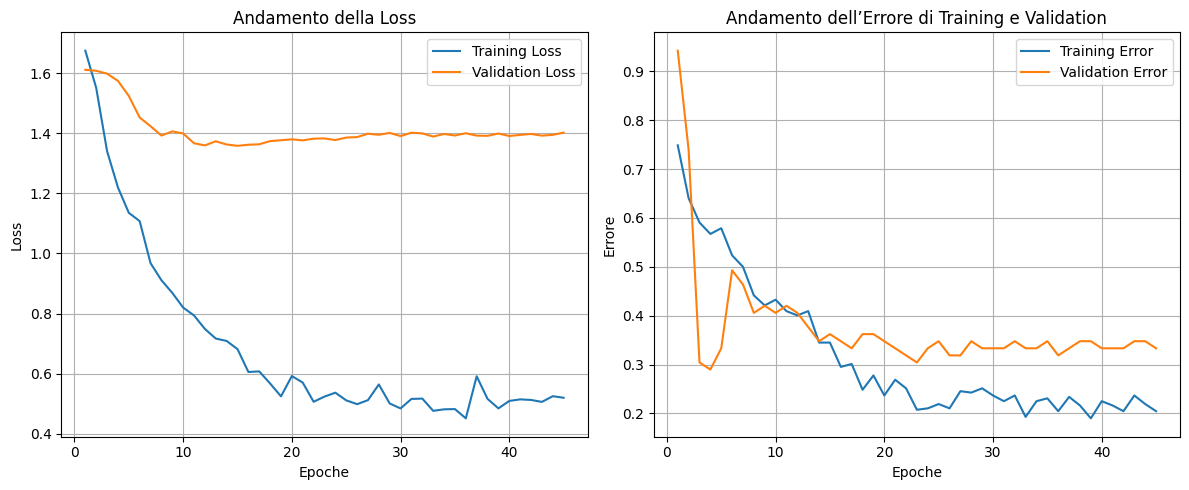

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Grafico della Loss
# La loss è il valore calcolato dalla funzione di perdita che misura quanto il modello si discosta dai target
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Andamento della Loss')
plt.legend()
plt.grid(True)

# Grafico dell’Errore (1 - Accuracy)
# Quanto il modello sbaglia in termini di percentuale di esempi
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [1 - x for x in train_accuracies], label='Training Error')
plt.plot(epochs_range, [1 - x for x in val_accuracies], label='Validation Error')
plt.xlabel('Epoche')
plt.ylabel('Errore')
plt.title('Andamento dell’Errore di Training e Validation')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


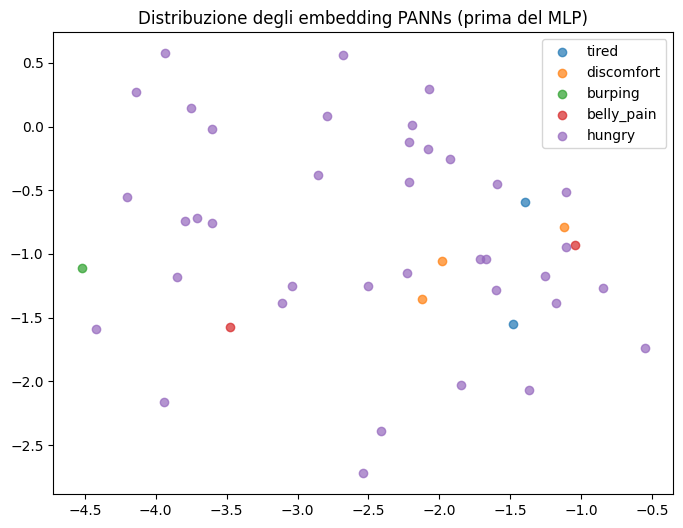

In [ ]:
#Grafico distribuzione degli embedding PANNs(prima di MLP)

mlp_model.eval()

embeddings = []
labels_all = []

with torch.no_grad():
    for emb, label in test_loader:  # emb già è embedding PANNs
        embeddings.append(emb.cpu().numpy())
        labels_all.extend(label.numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Riduzione dimensionale (es: t-SNE)
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Grafico
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(label2idx.keys()):
    plt.scatter(
        emb_2d[np.array(labels_all) == i, 0],
        emb_2d[np.array(labels_all) == i, 1],
        label=class_name, alpha=0.7
    )
plt.legend()
plt.title("Distribuzione degli embedding PANNs (prima del MLP)")
plt.show()


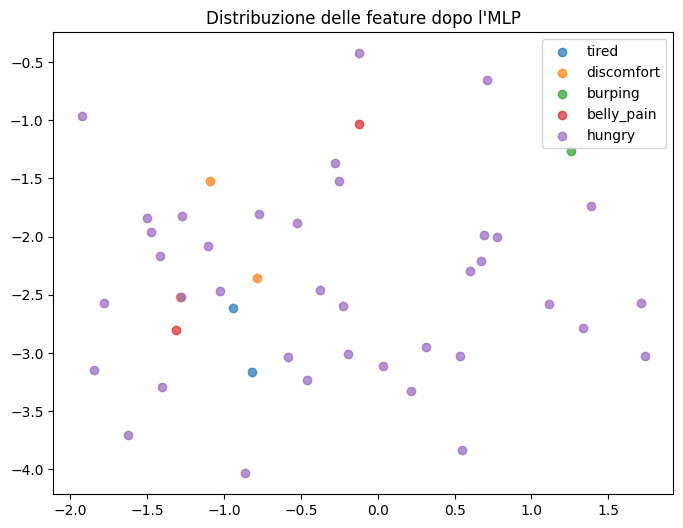

In [ ]:
mlp_model.load_state_dict(torch.load("best_model.pt", map_location=device))
mlp_model.eval()

#Visualizza feature dopo MLP
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch

embeddings_after = []
labels_all = []

with torch.no_grad():
    for emb, label in test_loader:
        emb, label = emb.to(device), label.to(device)
        features = mlp_model.extract_features(emb)  # <-- feature dopo il primo layer MLP
        embeddings_after.append(features.cpu().numpy())
        labels_all.extend(label.cpu().numpy())

embeddings_after = np.concatenate(embeddings_after, axis=0)
labels_all = np.array(labels_all)

#Grafico distribuzione embedding (dopo MLP)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
emb_2d_after = tsne.fit_transform(embeddings_after)

plt.figure(figsize=(8, 6))
for i, class_name in enumerate(label2idx.keys()):
    plt.scatter(
        emb_2d_after[labels_all == i, 0],
        emb_2d_after[labels_all == i, 1],
        label=class_name, alpha=0.7
    )
plt.legend()
plt.title("Distribuzione delle feature dopo l'MLP")
plt.show()


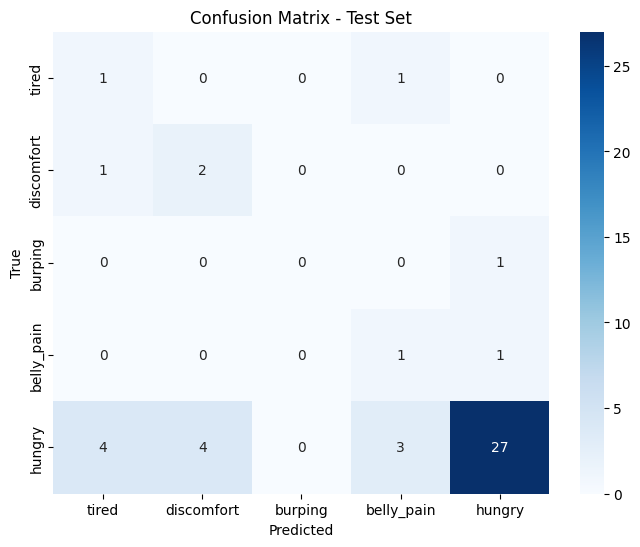


 Classification Report:
              precision    recall  f1-score   support

       tired       0.17      0.50      0.25         2
  discomfort       0.33      0.67      0.44         3
     burping       0.00      0.00      0.00         1
  belly_pain       0.20      0.50      0.29         2
      hungry       0.93      0.71      0.81        38

    accuracy                           0.67        46
   macro avg       0.33      0.48      0.36        46
weighted avg       0.81      0.67      0.72        46



In [ ]:
#Matrice di confusione - classificazione multiclasse
mlp_model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for spec, label in test_loader:
        spec, label = spec.to(device), label.to(device)
        outputs = mlp_model(spec)
        _, predicted = outputs.max(1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(label.cpu().numpy())

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label2idx.keys()),
            yticklabels=list(label2idx.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Report completo (precision, recall, f1)
print("\n Classification Report:")
print(classification_report(test_labels, test_preds, target_names=list(label2idx.keys())))




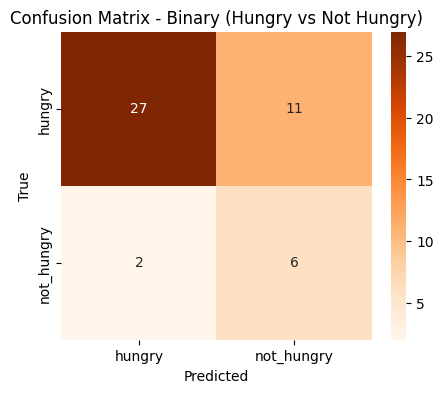


=== Classification Report (BINARY: hungry vs not_hungry) ===
              precision    recall  f1-score   support

      hungry       0.93      0.71      0.81        38
  not_hungry       0.35      0.75      0.48         8

    accuracy                           0.72        46
   macro avg       0.64      0.73      0.64        46
weighted avg       0.83      0.72      0.75        46



In [ ]:
#Matrice di cofnusione - collasso in classificazione binaria

# Valutazione finale
mlp_model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for spec, label in test_loader:
        spec, label = spec.to(device), label.to(device)
        outputs = mlp_model(spec)
        _, predicted = outputs.max(1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(label.cpu().numpy())

# Mappa indici -> label
idx2label = {v: k for k, v in label2idx.items()}

# Funzione di collasso: hungry (0) - not_hungry (1)
def collapse_to_binary(y):
    return [0 if idx2label[i].lower() == "hungry" else 1 for i in y]

# Conversione
binary_true  = collapse_to_binary(test_labels)
binary_preds = collapse_to_binary(test_preds)

# Confusion matrix (binaria)
cm_bin = confusion_matrix(binary_true, binary_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["hungry", "not_hungry"],
            yticklabels=["hungry", "not_hungry"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Binary (Hungry vs Not Hungry)")
plt.show()

# Report binario (precision, recall, F1)
print("\n=== Classification Report (BINARY: hungry vs not_hungry) ===")
print(classification_report(binary_true, binary_preds, target_names=["hungry", "not_hungry"]))
